In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

This model uses data from the [UCI ML Repository](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)

In [4]:
from ucimlrepo import fetch_ucirepo

diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
print(f"\nVariable Information:\n{diabetes_130_us_hospitals_for_years_1999_2008.variables}")


Variable Information:
                        name     role         type demographic  \
0               encounter_id       ID                     None   
1                patient_nbr       ID                     None   
2                       race  Feature  Categorical        Race   
3                     gender  Feature  Categorical      Gender   
4                        age  Feature  Categorical         Age   
5                     weight  Feature  Categorical        None   
6          admission_type_id  Feature  Categorical        None   
7   discharge_disposition_id  Feature  Categorical        None   
8        admission_source_id  Feature  Categorical        None   
9           time_in_hospital  Feature      Integer        None   
10                payer_code  Feature  Categorical        None   
11         medical_specialty  Feature  Categorical        None   
12        num_lab_procedures  Feature      Integer        None   
13            num_procedures  Feature      Integer   

/opt/anaconda3/lib/python3.12/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [6]:
data = pd.read_csv("diabetes_data/diabetic_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [8]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [36]:
data["patient_nbr"].nunique()

71518

In total there are 101766 entries but only 71518 patients. Need to stratify split training and testing by patient ID (patient_nbr column)
### Part 1: Exploratory Data Analysis
Examine numerical and categorical columns separately

In [11]:
diabetes_130_us_hospitals_for_years_1999_2008.variables.columns

Index(['name', 'role', 'type', 'demographic', 'description', 'units',
       'missing_values'],
      dtype='object')

In [13]:
# separate numerical and categorical columns
features_info = diabetes_130_us_hospitals_for_years_1999_2008.variables
num_cols = [features_info.iloc[i,0] for i in range(len(features_info)) if (features_info.iloc[i,2] == "Integer")]
cat_cols = [features_info.iloc[i,0] for i in range(len(features_info)) if (features_info.iloc[i,2] == "Categorical")]
print(f"Numerical Columns:\n{num_cols}")
print(f"Categorical Columns:\n{cat_cols}")

Numerical Columns:
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Categorical Columns:
['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


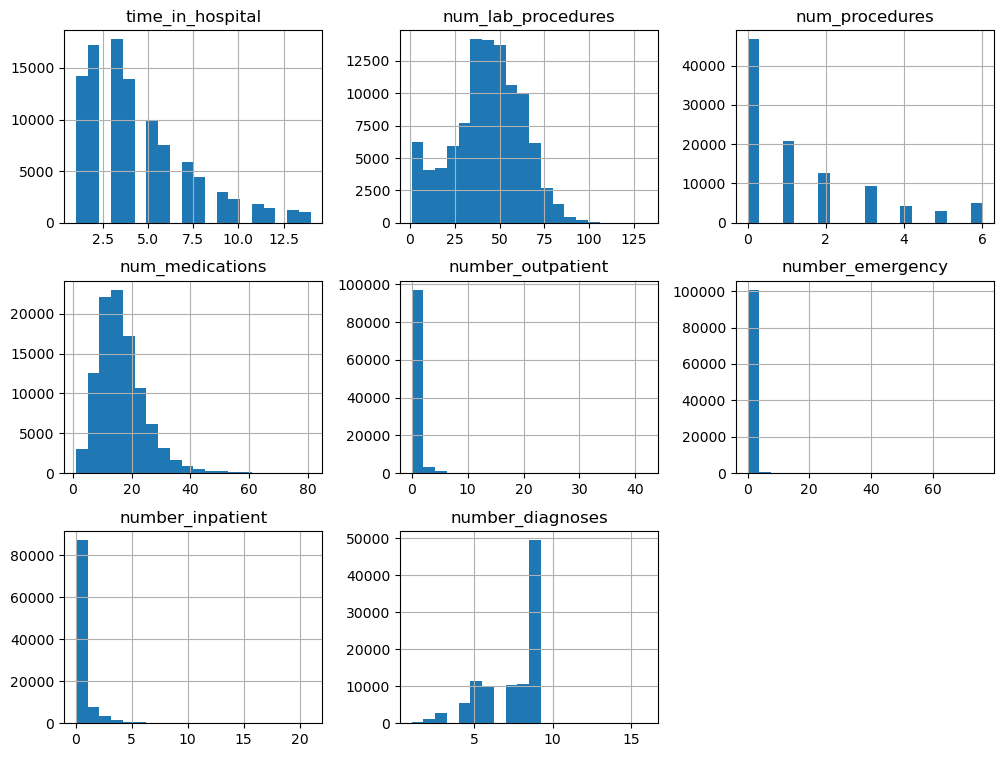

In [15]:
# graph histograms of numerical data
data[num_cols].hist(bins = 20, figsize = (12, 9))
plt.show()

Will need to apply transformation to tail-heavy numerical features\
(i.e. time_in_hospital, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient)

### Part 2: Data Preprocessing
**First**: split the data based on patient ID (make sure the same patient is only in one dataset)\
**Second**: data preprocessing on training data. Will need to:
* Apply transformations to select features
* Locate and deal with outliers, if any
* Deal with missing values
* Transform all binary categorical features (currently either "Yes" or "No", change to 1 and 0)
* Encode select categorical features
* Scale select features

**Split Training & Testing Data**\
Some patients have multiple records: need to make sure each patient only appears in either training or testing data to avoid model overfitting

In [40]:
from sklearn.model_selection import GroupShuffleSplit
X = data.drop(columns = "readmitted", axis = 1, inplace = False, errors = "ignore")
y = data["readmitted"]

# stratify split by patient id
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 42)
train_idx, test_idx = next(splitter.split(X, y, groups=data["patient_nbr"]))
X_train = X.iloc[train_idx].copy()
X_test = X.iloc[test_idx].copy()
y_train = y.iloc[train_idx].copy()
y_test = y.iloc[test_idx].copy()

# make sure split is corect
print(f"Unique number of patients in training data: {X_train["patient_nbr"].nunique()}")
print(f"Unique number of patients in testing data: {X_test["patient_nbr"].nunique()}")
print(f"Total number of unique patients in data: {data["patient_nbr"].nunique()}")
assert (X_train["patient_nbr"].nunique() + X_test["patient_nbr"].nunique()) == data["patient_nbr"].nunique()
X_train.drop(columns = ["encounter_id", "patient_nbr"], axis = 1, inplace = True, errors = "ignore")
X_test.drop(columns = ["encounter_id", "patient_nbr"], axis = 1, inplace = True, errors = "ignore")

Unique number of patients in training data: 57214
Unique number of patients in testing data: 14304
Total number of unique patients in data: 71518


**Transform Numerical Features**

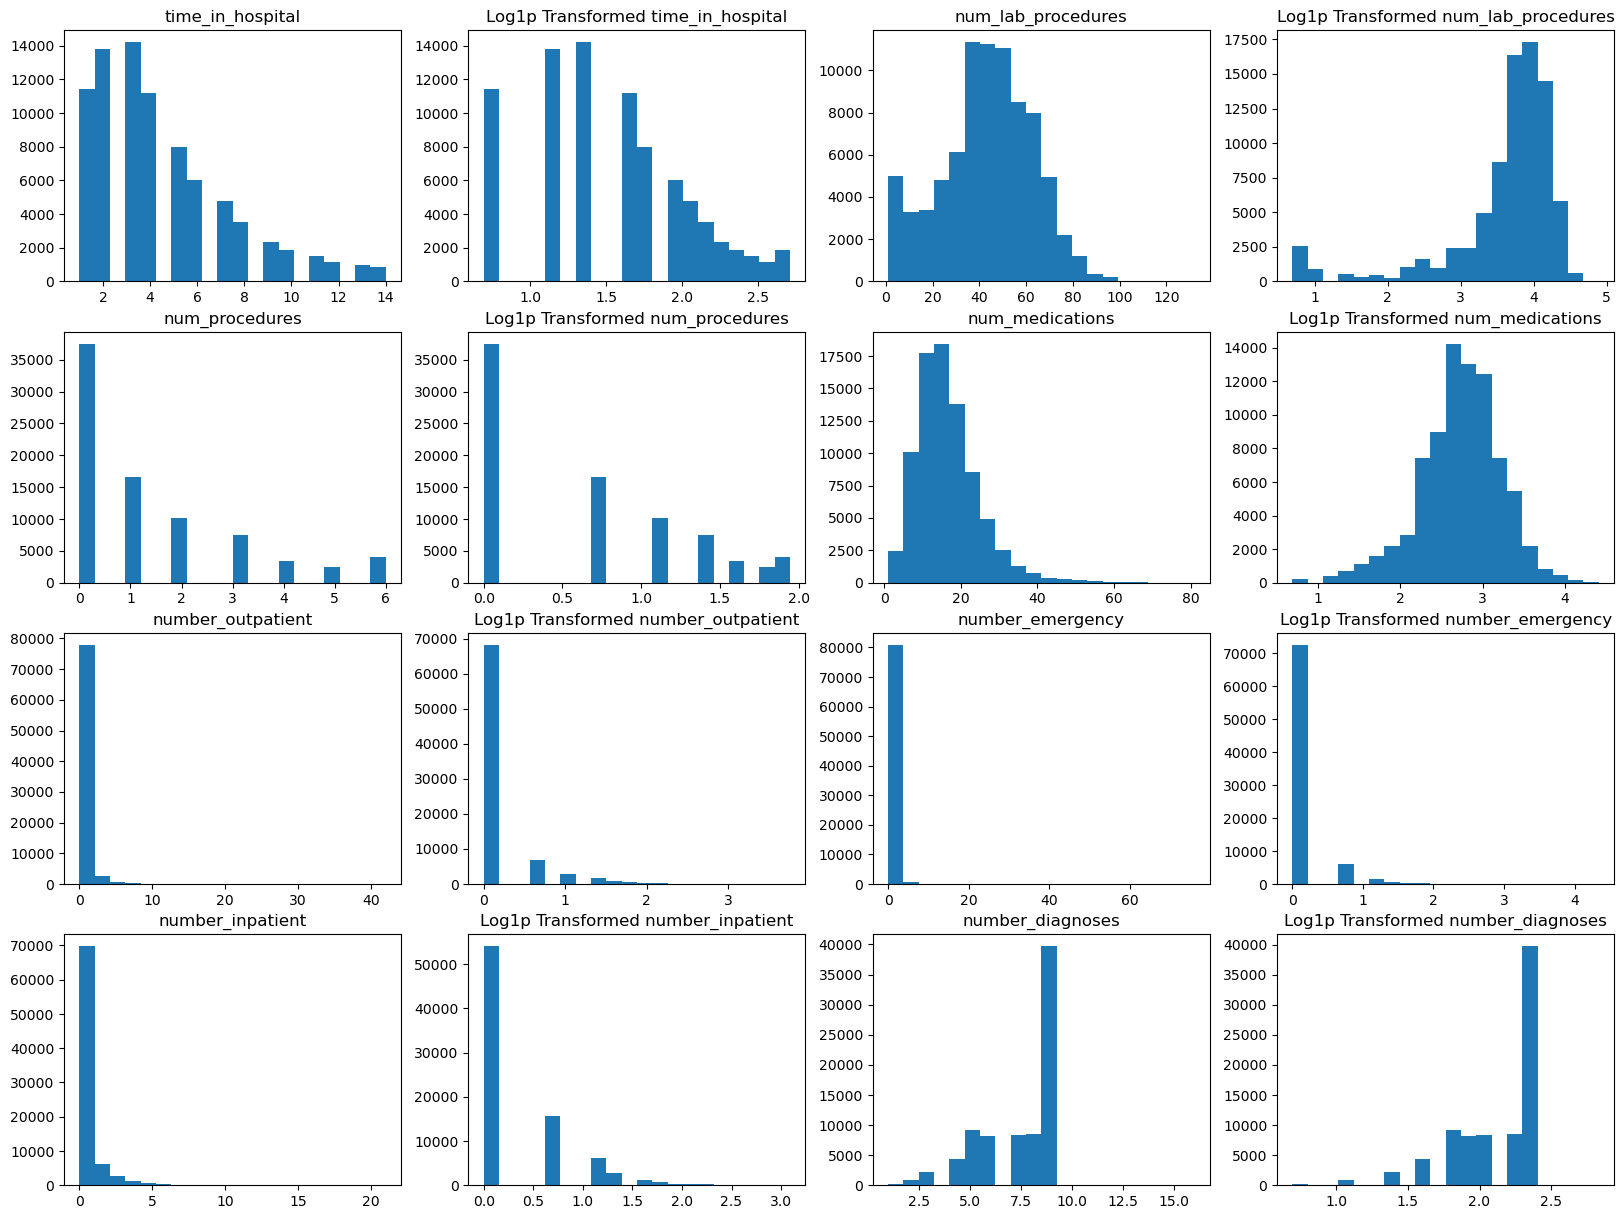

In [101]:
# try log transform (use log1p for all the 0s in the data)
# graph untransformed plots first
plt.figure(figsize = (20, 15))
for i in range(4):
    for j in range(1, 5, 2):
        plt.subplot(4, 4, (i * 4 + j))
        curr_col = num_cols[(i * 4 + j) // 2 ]
        plt.title(curr_col)
        plt.hist(X_train[curr_col], bins = 20)
# graph transformd plots
for i in range(4):
    for j in range(2, 5, 2):
        plt.subplot(4, 4, (i * 4 + j))
        curr_col = num_cols[(i * 4 + j) // 2 - 1]
        plt.title("Log1p Transformed " + curr_col)
        plt.hist(np.log1p(X_train[curr_col]), bins = 20)
plt.show()

In [71]:
# try quantile transform
from sklearn.preprocessing import QuantileTransformer
qt_test = QuantileTransformer(output_distribution = "normal", random_state = 42)
X_train_num_transformed = qt_test.fit_transform(X_train[num_cols])

In [75]:
X_train_num_transformed

array([[-5.19933758, -0.1995381 , -5.19933758, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-0.28744217,  0.77483284, -5.19933758, ..., -5.19933758,
        -5.19933758,  0.68793853],
       [-0.77822491, -1.36525737,  1.54179621, ..., -5.19933758,
         0.67685415, -0.67370246],
       ...,
       [-5.19933758,  0.45424896, -5.19933758, ..., -5.19933758,
        -5.19933758,  3.2391082 ],
       [ 1.48276018,  0.03513515,  0.59693534, ..., -5.19933758,
         0.67685415,  0.68793853],
       [ 0.68001258, -1.29536254,  0.96942671, ..., -5.19933758,
        -5.19933758,  0.68793853]])

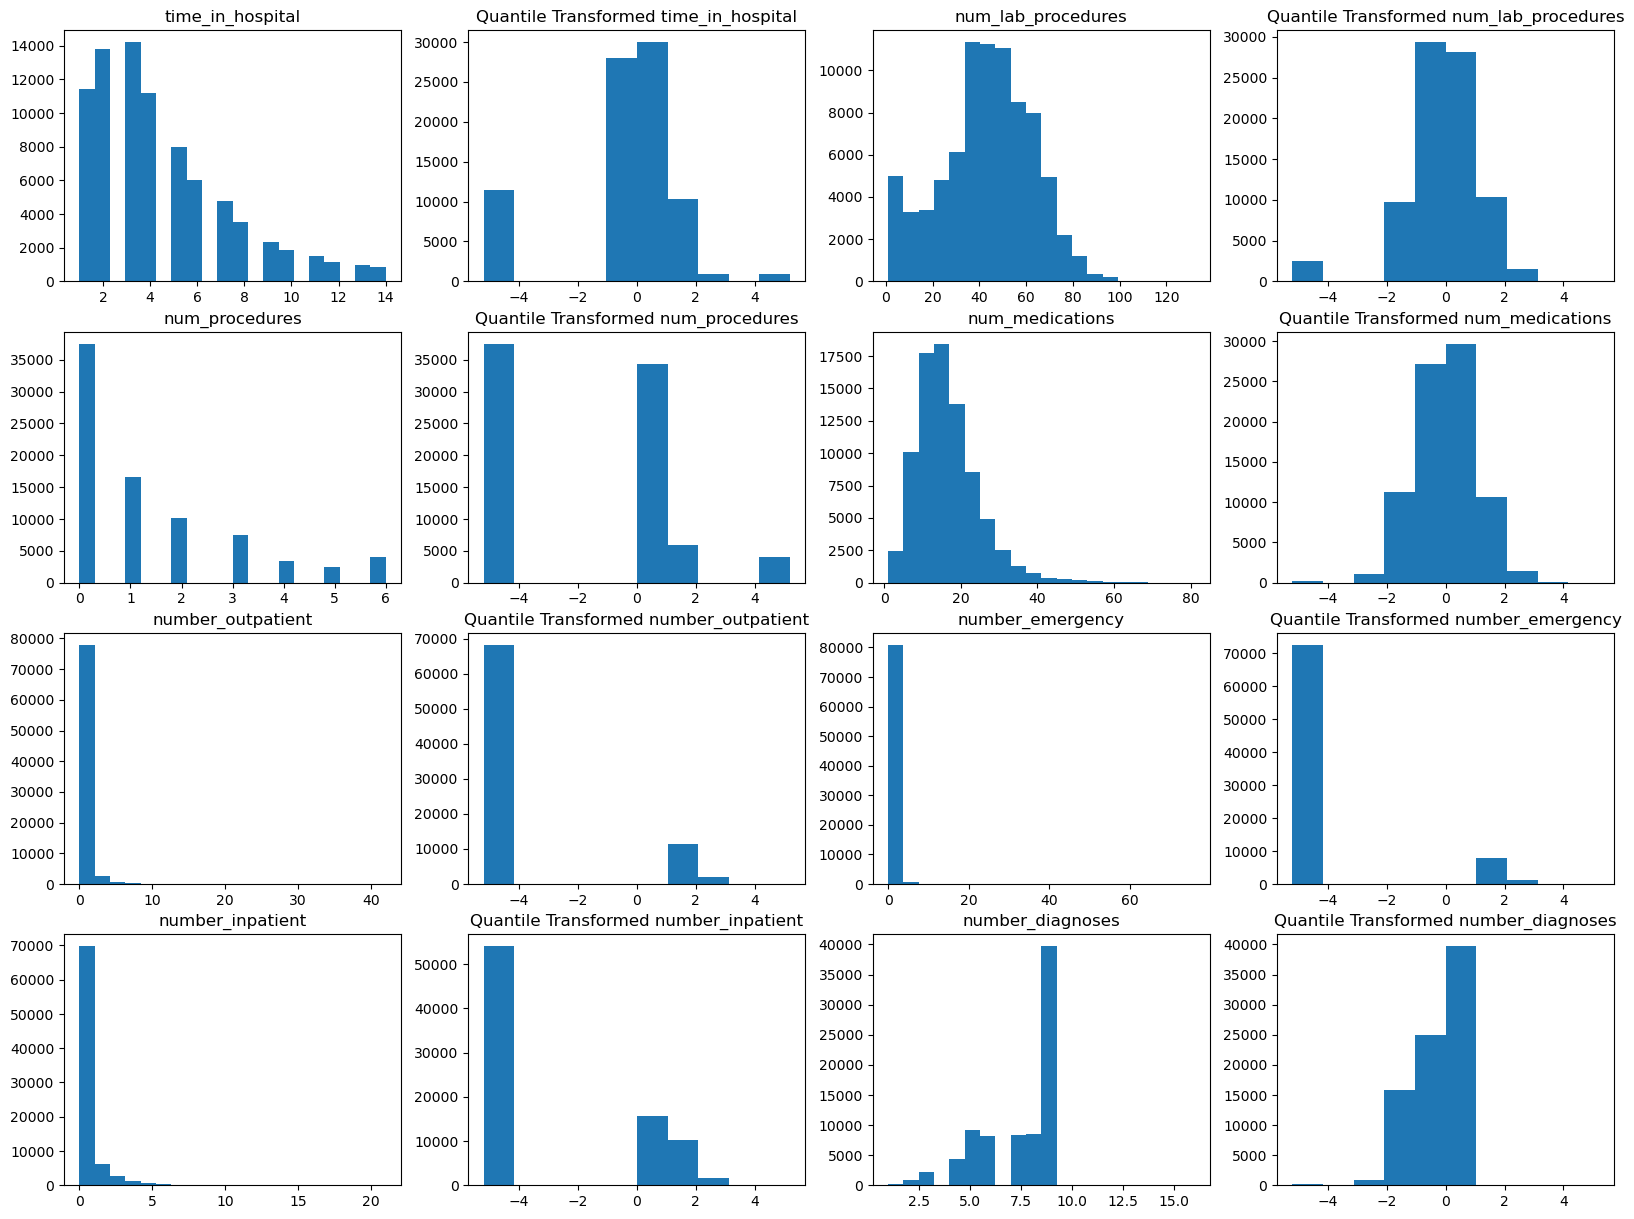

In [96]:
# graph untransformed plots first
plt.figure(figsize = (20, 15))
for i in range(4):
    for j in range(1, 5, 2):
        plt.subplot(4, 4, (i * 4 + j))
        curr_col = num_cols[(i * 4 + j) // 2 ]
        plt.title(curr_col)
        plt.hist(X_train[curr_col], bins = 20)
# graph transformd plots
for i in range(4):
    for j in range(2, 5, 2):
        plt.subplot(4, 4, (i * 4 + j))
        curr_col = num_cols[(i * 4 + j) // 2 - 1]
        plt.title("Quantile Transformed " + curr_col)
        plt.hist(X_train_num_transformed[:,((i * 4 + j) // 2 - 1)])
plt.show()

Final transformation plan:\
Leave as is: \["time_in_hospital", "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses"\]\
Quantile transform: \["num_lab_procedures", "num_procedures", "num_medications"\]\
Consider adding binary presence flag if performance is poor

**Handle Missing Values**

Find Missing Values

In [19]:
missing_cols = [features_info.iloc[i,0] for i in range(len(features_info)) if (features_info.iloc[i,6] == "yes")]
missing_cols

['race',
 'weight',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3']

In [21]:
print(f"Missing race entries: {len(data[data["race"] == "?"])} / 101766")
print(f"Missing weight entries: {len(data[data["weight"] == "?"])} / 101766")
print(f"Missing payer_code entries: {len(data[data["payer_code"] == "?"])} / 101766")
print(f"Missing medical_specialty entries: {len(data[data["medical_specialty"] == "?"])} / 101766")
print(f"Missing diag_1 entries: {len(data[data["diag_1"] == "?"])} / 101766")
print(f"Missing diag_2 entries: {len(data[data["diag_2"] == "?"])} / 101766")
print(f"Missing diag_3 entries: {len(data[data["diag_3"] == "?"])} / 101766")

Missing race entries: 2273 / 101766
Missing weight entries: 98569 / 101766
Missing payer_code entries: 40256 / 101766
Missing medical_specialty entries: 49949 / 101766
Missing diag_1 entries: 21 / 101766
Missing diag_2 entries: 358 / 101766
Missing diag_3 entries: 1423 / 101766
